# OFFLINE PATH PLANNING OPTIMISATION
This notebook elaborates the testing and development of an offline path planning optimisation pipeline to generate a safe and feasible reference path for a ego vehicle. The pipeline takes a set of coarsely placed waypoints and adjusts their localisation so as to comply with certain **path curvature** constraints in view of the vehicle's size and steering capability. The adjusted waypoints should be as close as possible to the original waypoints without violating the curvature constraints.

## Setup

### Installation
Before beginning, it is important to install all the dependencies to run all cells in this notebook. You can do that by running the following cell after converting the Markdown into code.

!pip install -r requirements.txt

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize

### Generating Waypoints
To easily generate waypoints for testing, we will use a modified version of my [Waypoint Generator](https://github.com/winstxnhdw/WaypointGenerator) script. The generated waypoints are exported as a CSV file and can be imported again using the pandas library.

In [4]:
%matplotlib widget

class ClickGenerator:

    def __init__(self, ax, fig, map_size, line_colour, point_colour):
        
        self.x = []
        self.y = []

        self.ax = ax
        self.fig = fig
        self.map_size = map_size
        self.line_colour = line_colour
        self.point_colour = point_colour

    def generate(self):

        def onclick(event):

            self.x.append(event.xdata)
            self.y.append(event.ydata)

            self.ax.plot(self.x, self.y, '-', color=self.line_colour)
            self.ax.plot(self.x, self.y, '.', color=self.point_colour)

            self.fig.canvas.draw()

            axis = {'X-axis': self.x, 'Y-axis': self.y}
            df = pd.DataFrame(axis, columns= ['X-axis', 'Y-axis'])
            df.to_csv("waypoints.csv", index = False)

        def onpress(event):

            # Undo last point
            if event.key == 'z':
                try:
                    self.x.pop()
                    self.y.pop()

                except:
                    pass
            
            # Clear all the points
            elif event.key == 'x':
                del self.x[:]
                del self.y[:]

            # Connect the first and last points
            elif event.key == 'c':
                try:
                    self.x.append(self.x[0])
                    self.y.append(self.y[0])

                except:
                    pass
        
            else:
                pass
        
            plt.cla()
            plt.grid()
            self.ax.set_xlim(-self.map_size, self.map_size)
            self.ax.set_ylim(-self.map_size, self.map_size)
            self.ax.plot(self.x, self.y, '-', color=self.line_colour)
            self.ax.plot(self.x, self.y, '.', color=self.point_colour)
            self.fig.canvas.draw()

            axis = {'X-axis': self.x, 'Y-axis': self.y}
            df = pd.DataFrame(axis, columns= ['X-axis', 'Y-axis'])
            df.to_csv("waypoints.csv", index = False)

        self.fig.canvas.mpl_connect('button_press_event', onclick)
        self.fig.canvas.mpl_connect('key_press_event', onpress)

def main():

    # Parameters
    map_size = 50
    line_colour = '#F0A39A'
    point_colour = '#383831'

    fig = plt.figure()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.resizable = True
    
    ax = plt.axes()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-map_size, map_size)
    ax.set_ylim(-map_size, map_size)

    click_gen = ClickGenerator(ax, fig, map_size, line_colour, point_colour)
    click_gen.generate()

    plt.grid()
    plt.show()

if __name__ == '__main__':
    main()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Importing the Generated Waypoints

In [6]:
dir_path = 'waypoints.csv'
df = pd.read_csv(dir_path)
wx = df['X-axis'].values.tolist()
wy = df['Y-axis'].values.tolist()

if len(wx) != len(wy):
    raise Exception("Waypoints are not valid. Length of axes do not match.")

else:
    wn = len(wx)
    print("Number of generated waypoints: {}".format(wn))

Number of generated waypoints: 9


## Focused Trajectory Planning for Autonomous On-Road Driving
Although this paper heaviliy emphasises on its trajectory planning, we will only be covering the section on path planning as they are relevant to goals of this notebook. The authors proposed a two-step approach to path planning. First, a seeding path is interpolated over a set of coarse waypoints after solving the shortest-path problem in the presence of obstacles. Second, the seeding path is further optimised to minimise cumulative lateral offset and curvature. However, for the sake of simplicity, we will make the following few assumptions.

1. There are no obstacles present.
2. The seeding path is the centre of the road.

This will allow us to easily set the maximum lateral offset constraint. Additionally, we will not be solving the shortest-path problem. More details about this approach can be found in the original paper [here](https://www.ri.cmu.edu/pub_files/2013/6/IV2013-Tianyu.pdf).

### Constructing the Seeding Path
According to the authors, if the seeding path is curvature-discontinous, the algorithm would take longer to converge. They suggest performing cubic interpolation to generate the seeding path. Since the road geometry and the seeding path is the same, the seeding path P^{\text{seed}} can be expressed as a set of $N$ points, sampled at $\Delta{s}$ intervals. This is written as,
$$
P^{\text{seed}} = \{P^{\text{seed}}_i \ | \ i = 0 \ ...\ N-1 \}.
$$

In [10]:
from bisect import bisect

class Spline:

    def __init__(self, x, y):
        
        self.x = x
        self.y = y

        self.a = y
        self.b = []
        self.d = []

        dim_size = max(len(x), len(y))
        h = np.diff(x)

        A = self.matrixA(h, dim_size)
        B = self.matrixB(h, dim_size)
        self.c = np.linalg.solve(A, B)

        for i in range(dim_size - 1):
            self.b.append((self.a[i + 1] - self.a[i])/h[i] - h[i]*(self.c[i + 1] + 2.0*self.c[i]) / 3.0)
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))

    def matrixA(self, h, size):
        
        A = np.zeros((size, size))
        A[0, 0] = 1.0

        for i in range(size - 1):
            if i != (size - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])

            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[size - 1, size - 2] = 0.0
        A[size - 1, size - 1] = 1.0

        return A

    def matrixB(self, h, size):
        
        B = np.zeros(size)

        for i in range(size - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
            
        return B

    def solve_function(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            deltax = x - self.x[i]
            result = self.a[i] + self.b[i]*deltax + self.c[i]*deltax**2.0 + self.d[i]*deltax**3.0

            return result

    def solve_1st_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            deltax = x - self.x[i]
            result = self.b[i] + 2.0*self.c[i]*deltax + 3.0*self.d[i]*deltax**2.0

            return result

    def solve_2nd_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            deltax = x - self.x[i]
            result = 2.0*self.c[i] + 6.0*self.d[i] * deltax

            return result

    def search_index(self, x):

        i = bisect(self.x, x) - 1

        return i

class Spline2D:

    def __init__(self, x, y):

        self.ds = None

        self.s = self.calculate_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def calculate_s(self, x, y):
        
        deltax = np.diff(x)
        deltay = np.diff(y)
        self.ds = np.hypot(deltax, deltay)

        s = [0]
        s.extend(np.cumsum(self.ds))

        return s

    def calculate_position(self, s):
        
        x = self.sx.solve_function(s)
        y = self.sy.solve_function(s)

        return x, y

    def calculate_yaw(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        yaw = np.arctan2(dy, dx)

        return yaw

    def calculate_curvature(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        ddx = self.sx.solve_2nd_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        ddy = self.sy.solve_2nd_derivative(s)

        k = (ddy*dx - ddx*dy) / ((dx**2 + dy**2)**(3 / 2))

        return k

def generate_cubic_path(x, y, ds=0.05):

    sp2d = Spline2D(x, y)
    s = np.arange(0, sp2d.s[-1], ds)

    px = []
    py = []
    pyaw = []
    pk = []

    for i in s:
        ix, iy = sp2d.calculate_position(i)
        px.append(ix)
        py.append(iy)
        pyaw.append(sp2d.calculate_yaw(i))
        pk.append(sp2d.calculate_curvature(i))

    return px, py, pyaw, pk

ds = 1.0
%time px, py, pyaw, pk = generate_cubic_path(wx, wy, ds)

print("Number of points in the seeding path: {}".format(len(pk)))
print("Linear distance between each point: {} m".format(ds))

Wall time: 3.96 ms
Number of points in the seeding path: 210
Linear distance between each point: 1.0 m


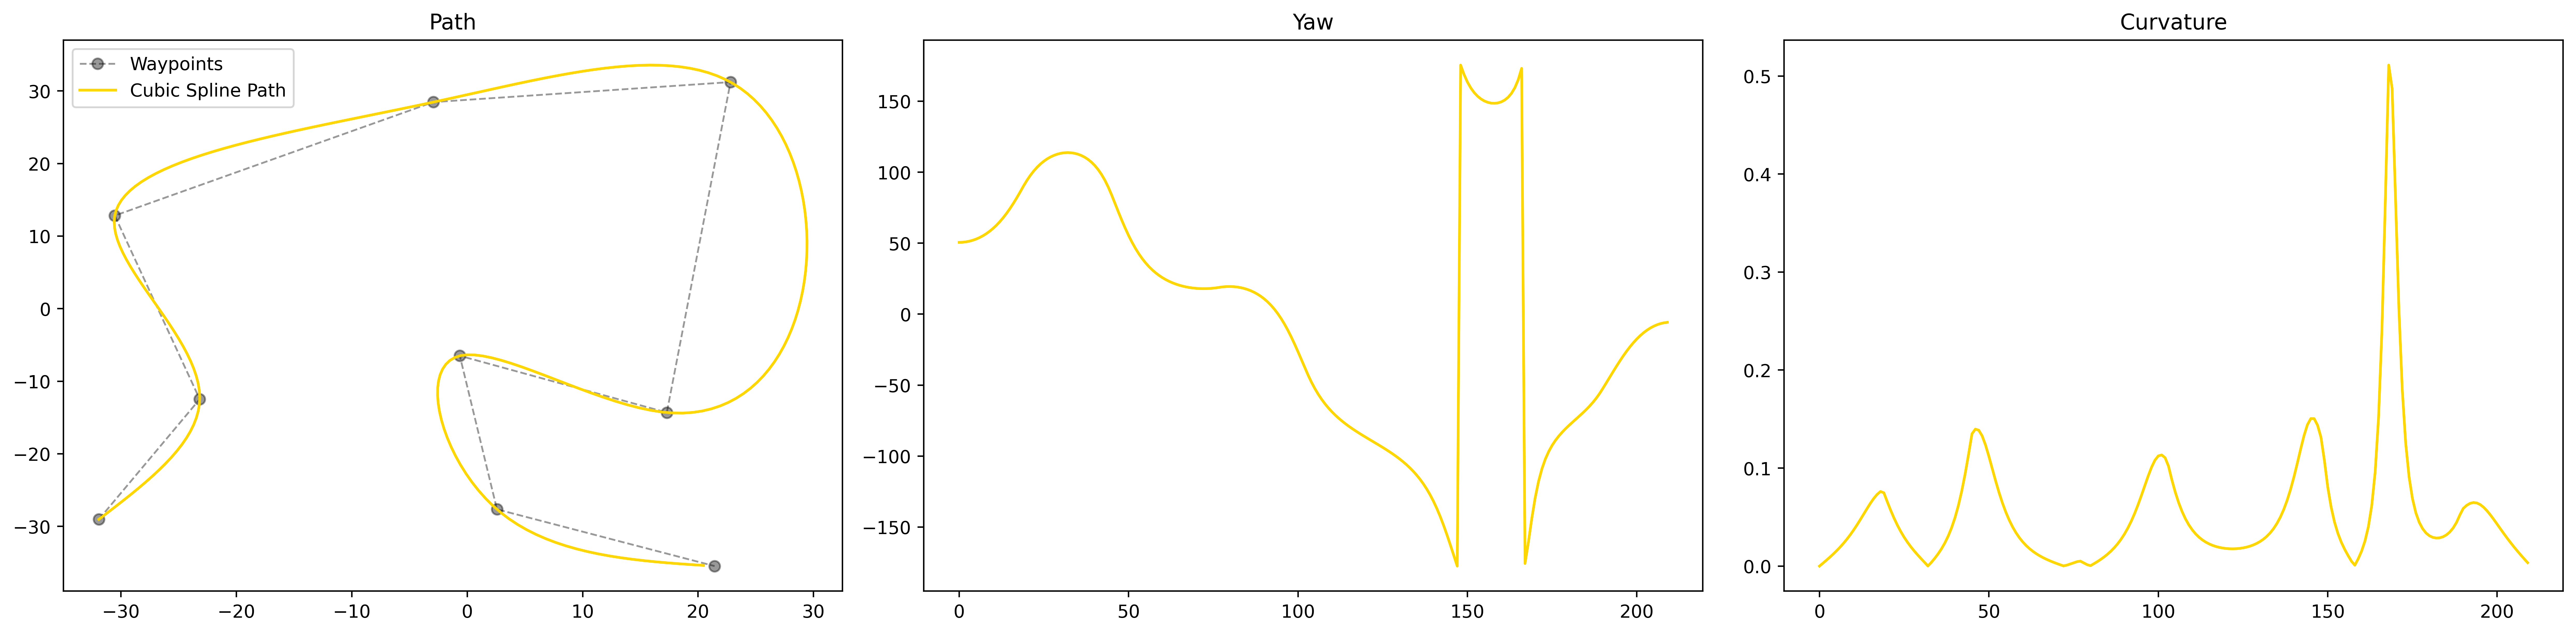

In [15]:
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=500)

ax[0].set_title('Path')
ax[0].plot(wx, wy, '--ok', linewidth=1, alpha=0.4, label='Waypoints')
ax[0].plot(px, py, '-', color='gold', label='Cubic Spline Path')
ax[0].legend()

ax[1].set_title('Yaw')
ax[1].plot(np.rad2deg(pyaw), color='gold')

ax[2].set_title('Curvature')
ax[2].plot(np.absolute(pk), color='gold')

plt.tight_layout()
plt.show()

### Calculate Yaw of Waypoints (Not Working)
We will need to calculate the yaw of each waypoints so that we can set our road boundaries later.

In [22]:
def solve_1st_derivative(x, y):

    dx = []
    dy = []

    for i in range(0, max(len(x), len(y)) - 1):
        dx.append(x[i+1] - x[i])
        dy.append(y[i+1] - y[i])

    dx.append(dx[-1])
    dy.append(dy[-1])

    return dx, dy

def calculate_curvature_and_yaw(x, y):

    dx, dy = solve_1st_derivative(x, y)
    ddx, ddy = solve_1st_derivative(dx, dy)

    yaw = []
    k = []
    
    for i in range(0, max(len(x), len(y))):
        yaw.append(np.arctan2(dy[i], dx[i]))
        k.append((ddy[i]*dx[i] - ddx[i]*dy[i]) / ((dx[i]**2 + dy[i]**2)**(3/2)))

    return yaw, k

def calculate_curvature(x, y):

    dx, dy = solve_1st_derivative(x, y)
    ddx, ddy = solve_1st_derivative(dx, dy)

    k = []
    
    for i in range(0, max(len(x), len(y))):
        k.append((ddy[i]*dx[i] - ddx[i]*dy[i]) / ((dx[i]**2 + dy[i]**2)**(3/2)))

    return k

def calculate_yaw(x, y):

    dx, dy = solve_1st_derivative(x, y)

    yaw = []
    
    for i in range(0, max(len(x), len(y))):
        yaw.append(np.arctan2(dy[i], dx[i]))

    return yaw

# wyaw = calculate_yaw(wx, wy)

### Set constraint
For path planning, the only constraint given are the bounds of optimisation. They can be represented as,
$$
o_i + o_i^{\text{seed}} \in [r_i, \ l_i],
$$
where $o_i$ is the lateral offset from the seeding path, $o_i^{\text{seed}}$ is the lateral offset from the centre of the road, and the value pairs of $l_i$ and $r_i$ are the left and right road boundaries, respectively. Of course, since the seeding path is the middle of the road, the value of $o_i^{\text{seed}}$ is zero and can be ignored in our equations. Thus, we can rewrite the equation as,
$$
o_i \in [r_i, \ l_i].
$$

In [25]:
# Boundary constraints
lx = []
ly = []
rx = []
ry = []
bound = []
bounds = []

max_lateral_offset = 3

for i in range(0, len(pyaw)):
    lx.append(px[i] - max_lateral_offset*np.sin(pyaw[i]))
    ly.append(py[i] + max_lateral_offset*np.cos(pyaw[i]))
    rx.append(px[i] + max_lateral_offset*np.sin(pyaw[i]))
    ry.append(py[i] - max_lateral_offset*np.cos(pyaw[i]))

for _ in range(0, len(pyaw)):
    bound.append((-max_lateral_offset, max_lateral_offset))

bounds = tuple(bound)
print("Length of bounds: {}".format(len(bounds)))

Length of bounds: 210


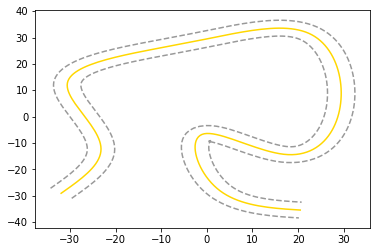

In [18]:
%matplotlib inline

plt.plot(px, py, '-', color='gold')
plt.plot(lx, ly, '--k', alpha=0.4)
plt.plot(rx, ry, '--k', alpha=0.4)

plt.show()

### Define the Objective Function
In order to minimise both cumulative curvature and lateral offset, a optimisation criterion must be formualated. The paper proposes the following optimisation criterion,
$$
\min(\sum^{N-1}_{i=0}{w_k \cdot ||k_i|| + (1 - w_k) \cdot |o_i|}),
$$
where the weight $w_k$ trades off between minimising cumulative curvature and lateral offset and $k_i$ is the path curvature.

In [28]:
def objective_fcn(lateral_offset):

    wk = 0.96
    ox = px.copy()
    oy = py.copy()

   # Curvature cost
    for n in range(0, len(pyaw)):
        ox[n] -= lateral_offset[n]*np.sin(pyaw[n])
        oy[n] += lateral_offset[n]*np.cos(pyaw[n])

    ok = calculate_curvature(ox, oy)

    # Curvature cost
    curvature_cost = wk * np.mean(np.absolute(ok))

    # Offset cost
    offset_cost = (1 - wk) * np.mean(np.absolute(lateral_offset))

    return offset_cost + curvature_cost

guess = np.zeros(len(pyaw))
objective_fcn(guess)

0.05309978007328513

### Optimise
The paper suggested the use of the Levenberg-Marquardt algorithm. However, for ease of use, we will be using another solver provided by SciPy's minimize() function.

In [38]:
%time result = minimize(objective_fcn, guess, bounds=bounds, options={'maxfun': 1000000})
print("Message: {}".format(result.message))
print("Success: {}".format(result.success))

Wall time: 2min
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Success: True


In [39]:
if result.success:
    ox = px.copy()
    oy = py.copy() 

    for n in range(0, len(pyaw)):
        ox[n] -= result.x[n]*np.sin(pyaw[n])
        oy[n] += result.x[n]*np.cos(pyaw[n])

    oyaw, ok = calculate_curvature_and_yaw(ox, oy)

    cum_ok = np.mean(np.absolute(ok))
    cum_pk = np.mean(np.absolute(pk))
    print("Cumulative curvature [Optimised]: {}".format(cum_ok))
    print("Cumulative curvature [Unoptimised]: {}".format(cum_pk))

else:
    raise Exception("Optimisation failed.")

Cumulative curvature [Optimised]: 0.05371083461623468
Cumulative curvature [Unoptimised]: 0.05530600519390872


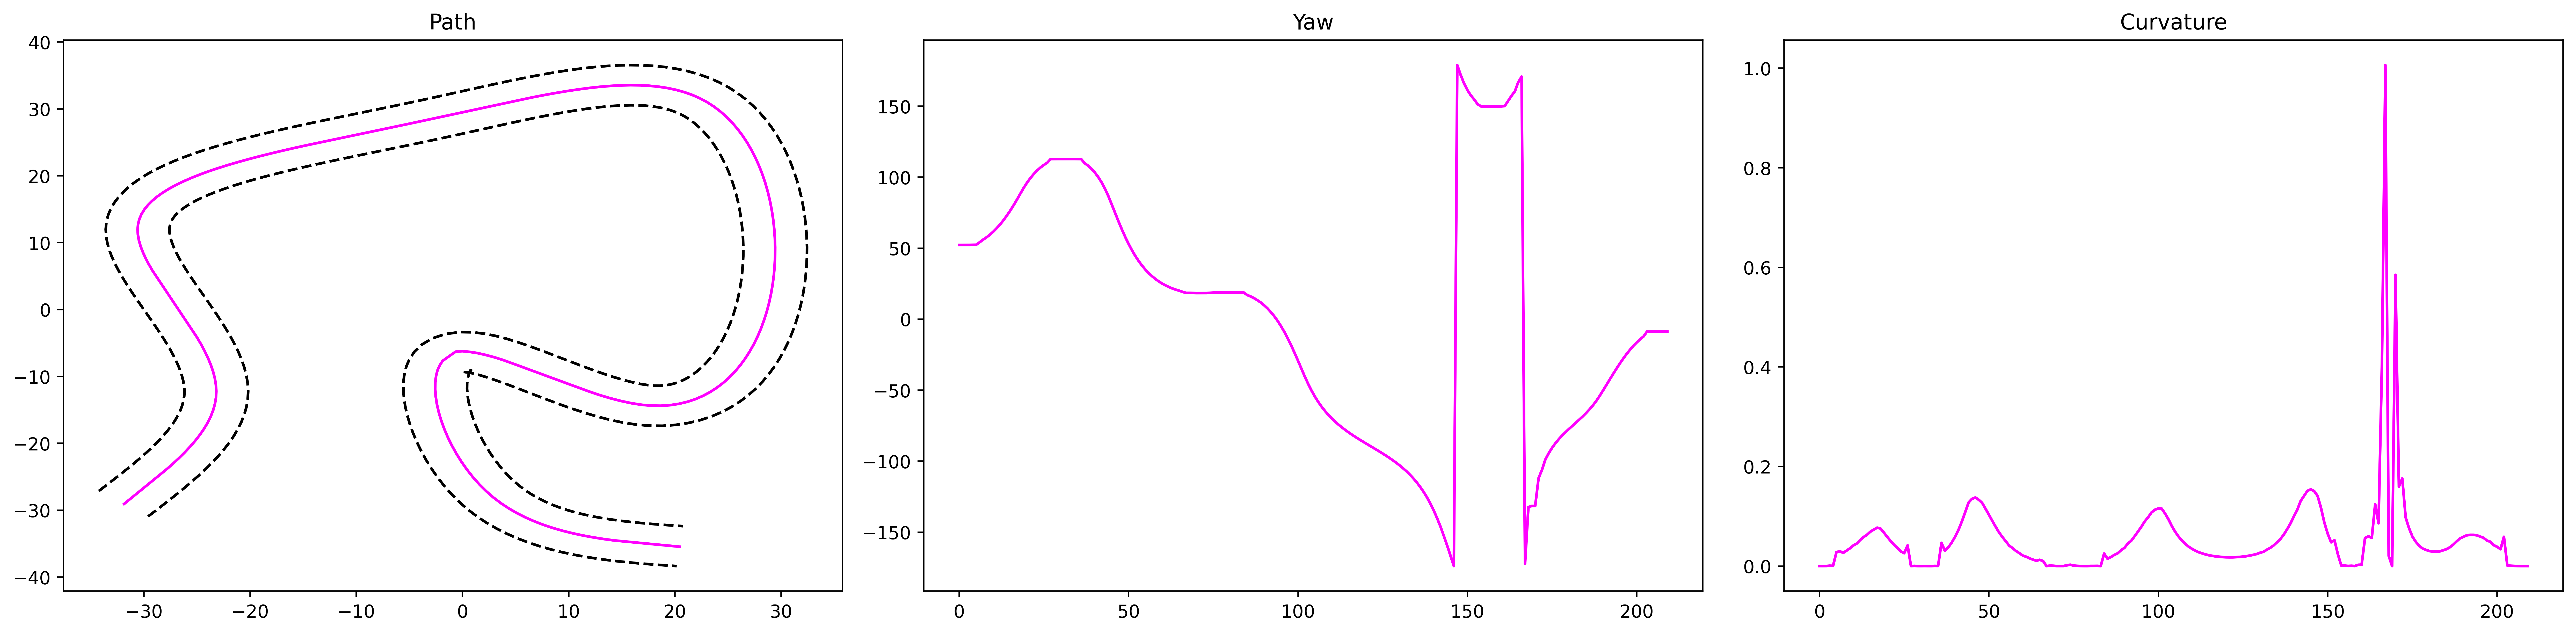

In [41]:
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=500)

ax[0].set_title('Path')
ax[0].plot(lx, ly, '--k')
ax[0].plot(rx, ry, '--k')
ax[0].plot(ox, oy, color='magenta')

ax[1].set_title('Yaw')
ax[1].plot(np.rad2deg(oyaw), color='magenta')

ax[2].set_title('Curvature')
ax[2].plot(np.absolute(ok), color='magenta')

plt.tight_layout()
plt.show()

### Comparison

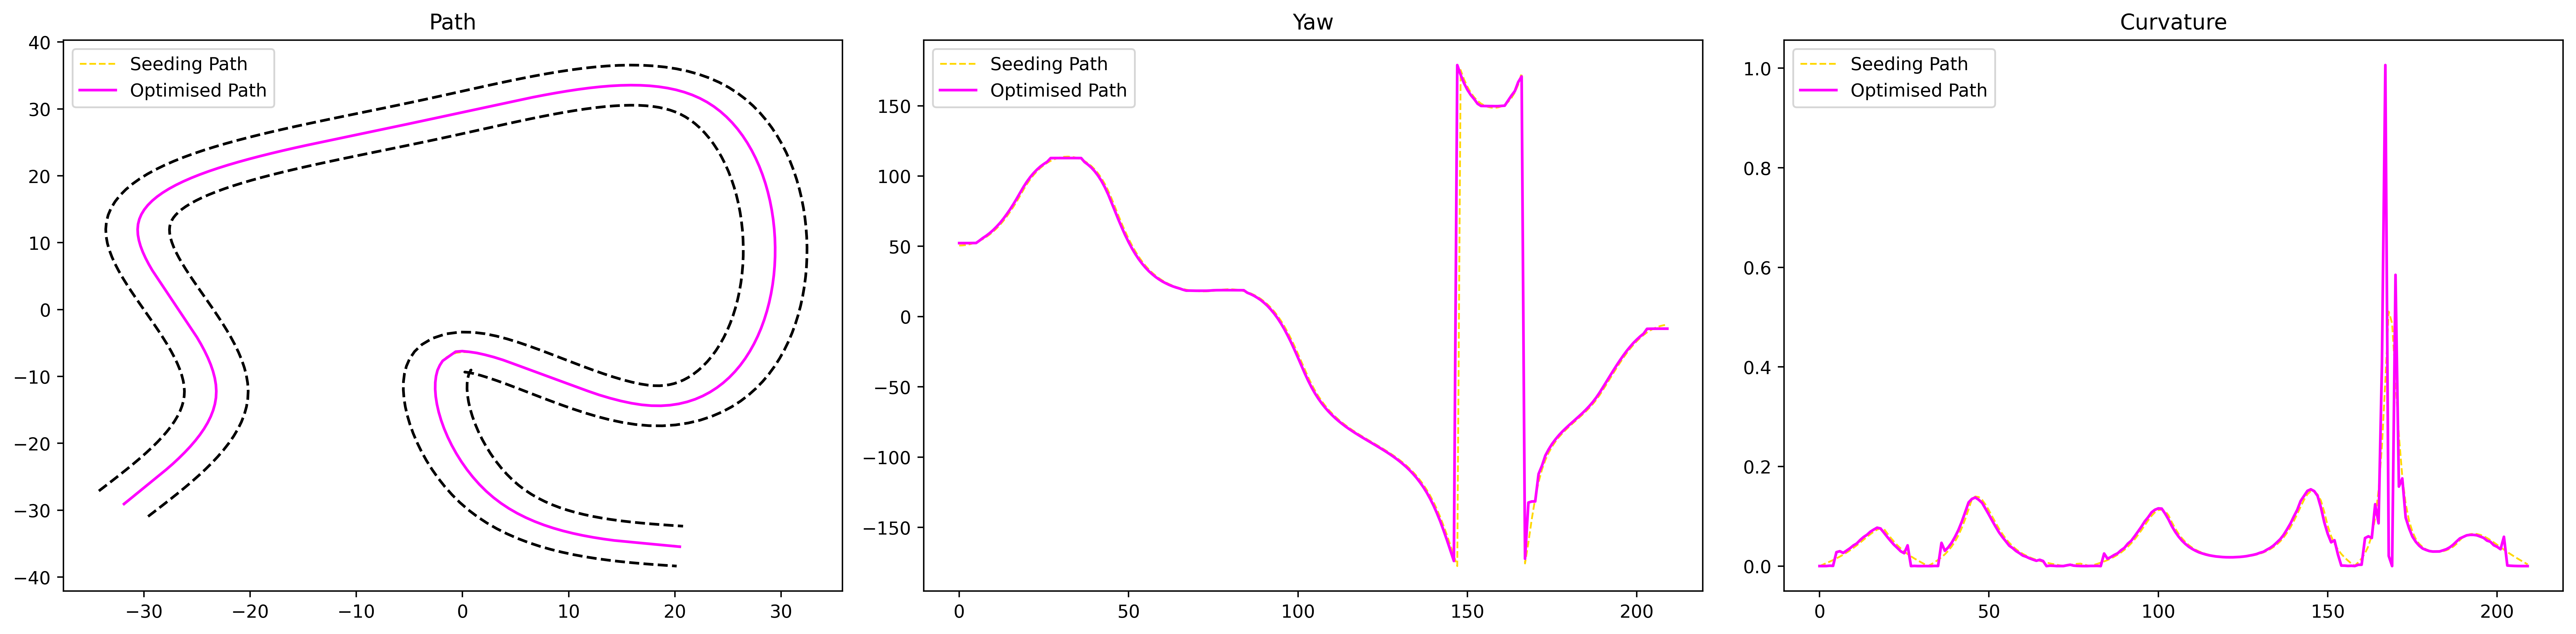

In [40]:
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=500)

ax[0].set_title('Path')
ax[0].plot(lx, ly, '--k')
ax[0].plot(rx, ry, '--k')
ax[0].plot(px, py, '--', color='gold', linewidth=1, label='Seeding Path')
ax[0].plot(ox, oy, color='magenta', label='Optimised Path')
ax[0].legend()

ax[1].set_title('Yaw')
ax[1].plot(np.rad2deg(pyaw), '--', color='gold', linewidth=1, label='Seeding Path')
ax[1].plot(np.rad2deg(oyaw), color='magenta', label='Optimised Path')
ax[1].legend()

ax[2].set_title('Curvature')
ax[2].plot(np.absolute(pk), '--', color='gold', linewidth=1, label='Seeding Path')
ax[2].plot(np.absolute(ok), color='magenta', label='Optimised Path')
ax[2].legend()

plt.tight_layout()
plt.show()

### Remarks

### Export Notebook as Markdown

!jupyter nbconvert main.ipynb --to markdown --output README.md